In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

pipe_pca_mlp = Pipeline([('pca', PCA(n_components=2)), ('mlp', MLPClassifier(hidden_layer_sizes=(15,10,5), max_iter=500))])
pipe_ica_mlp = Pipeline([('ica', FastICA(n_components = 2)), ('mlp', MLPClassifier(hidden_layer_sizes=(15,10,5), max_iter=500))])
pipe_lda_mlp = Pipeline([('lda', LinearDiscriminantAnalysis(n_components = 1)), ('mlp', MLPClassifier(hidden_layer_sizes=(15,10,5), max_iter=500))])

In [6]:
import tensorflow as tf

def SigXNet(input_shape, classes, X_train, Y_train, X_test, Y_test):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=input_shape),

      tf.keras.layers.MaxPooling1D(),
      tf.keras.layers.Conv1D(26, kernel_size=7, strides=1, padding='valid'),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.MaxPooling1D(),
      tf.keras.layers.Conv1D(13, kernel_size=5, strides=1, padding='valid'),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.MaxPooling1D(),
      tf.keras.layers.Conv1D(7, kernel_size=3, strides=1, padding='valid'),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(15, activation = 'selu'),
      tf.keras.layers.Dense(10, activation = 'selu'),
      tf.keras.layers.Dense(5, activation = 'selu'),
      tf.keras.layers.Dense(classes, activation='sigmoid')
  ], name = "SigXNet")

  model.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3), loss=tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])
  model.summary()

  onehot_y_train = tf.keras.utils.to_categorical(Y_train)
  onehot_y_test = tf.keras.utils.to_categorical(Y_test)

  reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
  history = model.fit(X_train, onehot_y_train, validation_data = (X_test, onehot_y_test), epochs = 50, callbacks = reducelr)

  return model, history

In [7]:
eeg_data_path = 'C:\\Users\\saumi\\Desktop\\Sem 6 project\\gans\\Dataset\\Epileptic Seizure Recognition.csv'


In [10]:
import pandas as pd
import numpy as np

In [12]:
eeg_df = pd.read_csv(eeg_data_path)

# Dropping the extra column
eeg_df = eeg_df.drop(['Unnamed'], axis = 1)

# Seperating the samples and labels data
x_data = eeg_df.drop('y', axis = 1)
y_data = eeg_df[['y']]

In [13]:
# Standard Scaling Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_data)
x_data_scaled = scaler.transform(x_data)

In [15]:
class0 = [2, 3, 4, 5]
class1 = [1]

for index, row in y_data.iterrows():
    if row['y'] in class0:
      row['y'] = 0
    elif row['y'] in class1:
      row['y'] = 1

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size = 0.20, random_state = 1)

In [16]:
pipe_pca_mlp.fit(x_train, y_train.to_numpy().ravel())


Pipeline(steps=[('pca', PCA(n_components=2)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(15, 10, 5), max_iter=500))])

In [17]:
pipe_ica_mlp.fit(x_train, y_train.to_numpy().ravel())


c:\Users\saumi\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Pipeline(steps=[('ica', FastICA(n_components=2)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(15, 10, 5), max_iter=500))])

In [18]:
pipe_lda_mlp.fit(x_train, y_train.to_numpy().ravel())


Pipeline(steps=[('lda', LinearDiscriminantAnalysis(n_components=1)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(15, 10, 5), max_iter=500))])

In [19]:
print('(PCA + MLP) Training Accuracy: ' + str(pipe_pca_mlp.score(x_train, y_train.to_numpy().ravel())) + ' Testing Accuracy: ' + str(pipe_pca_mlp.score(x_test, y_test.to_numpy().ravel())))
print('(ICA + MLP) Training Accuracy: ' + str(pipe_ica_mlp.score(x_train, y_train.to_numpy().ravel())) + ' Testing Accuracy: ' + str(pipe_ica_mlp.score(x_test, y_test.to_numpy().ravel())))
print('(LCA + MLP) Training Accuracy: ' + str(pipe_lda_mlp.score(x_train, y_train.to_numpy().ravel())) + ' Testing Accuracy: ' + str(pipe_lda_mlp.score(x_test, y_test.to_numpy().ravel())))
     

(PCA + MLP) Training Accuracy: 0.943695652173913 Testing Accuracy: 0.94
(ICA + MLP) Training Accuracy: 0.918804347826087 Testing Accuracy: 0.9208695652173913
(LCA + MLP) Training Accuracy: 0.8589130434782609 Testing Accuracy: 0.8543478260869565


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title = None, cmap = None, normalize = False):
    """
    Given a sklearn confusion matrix (cm), make a plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix ' + title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('\nPredicted label\n\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def plot_classification_report(cr, figsize = (10, 5), title = None, cmap = 'Purples'):
  acc_f1 = cr['accuracy']
  acc_support = cr['weighted avg']['support']
  acc_precision = None
  acc_recall = None

  cr['accuracy'] = {'precision': acc_precision, 'recall': acc_recall, 'f1-score': acc_f1, 'support': acc_support}

  plt.figure(figsize = figsize)
  plt.title('Classification Report ' + title)
  sns.heatmap(pd.DataFrame(cr).T, cmap = cmap, annot = True, cbar = False, fmt='g')
  plt.show()

def plot_cr_cm(model, x_data, y_true, labels, target_names, title = None, cmap = 'Purples', y_preds = None, model_type = 'keras'):
  if model_type == 'sklearn':
    y_preds = model.predict(x_data)

  confusionmatrix = confusion_matrix(y_true, y_preds)
  plot_confusion_matrix(cm = confusionmatrix, target_names = target_names, title = title, cmap = cmap)
  
  print('\n')
  classificationreport = classification_report(y_true, y_preds, labels = labels, target_names = target_names, output_dict = True)
  plot_classification_report(cr = classificationreport, title = title, cmap = cmap)

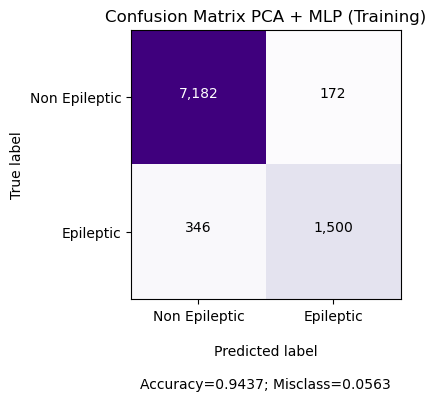

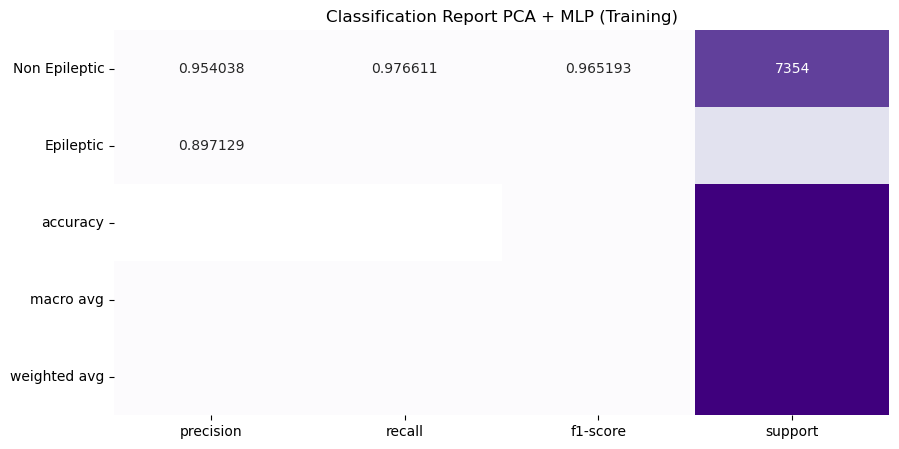

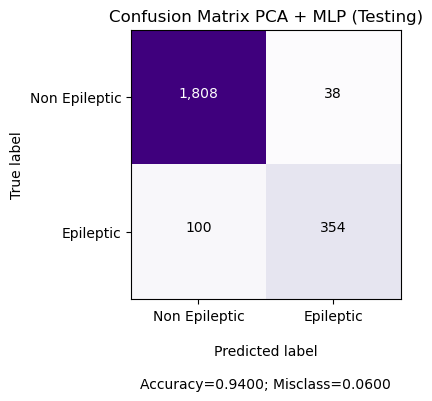

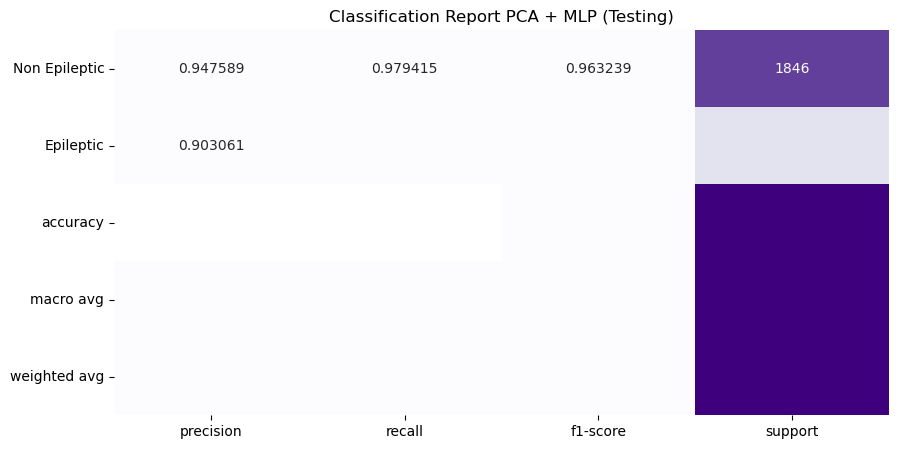

In [21]:
plot_cr_cm(pipe_pca_mlp, x_train, y_train, [0, 1], ['Non Epileptic', 'Epileptic'], 'PCA + MLP (Training)', model_type = 'sklearn')
plot_cr_cm(pipe_pca_mlp, x_test, y_test, [0, 1], ['Non Epileptic', 'Epileptic'], 'PCA + MLP (Testing)', model_type = 'sklearn')
     

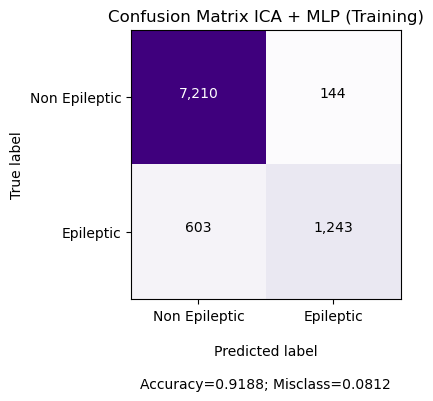

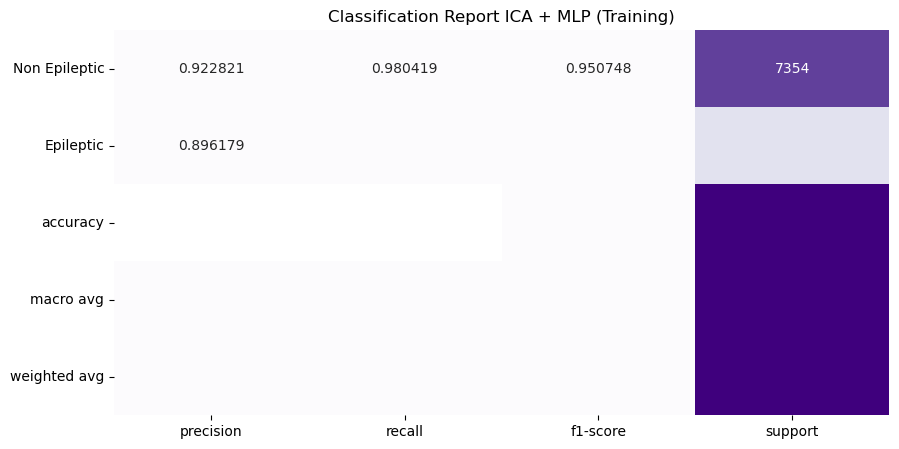

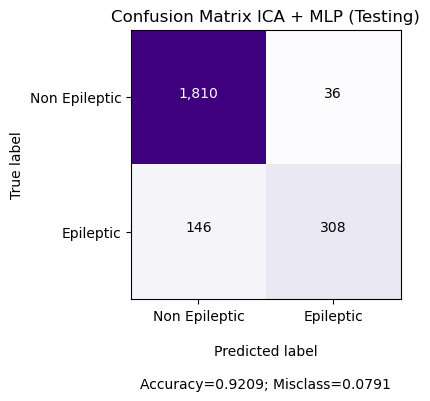

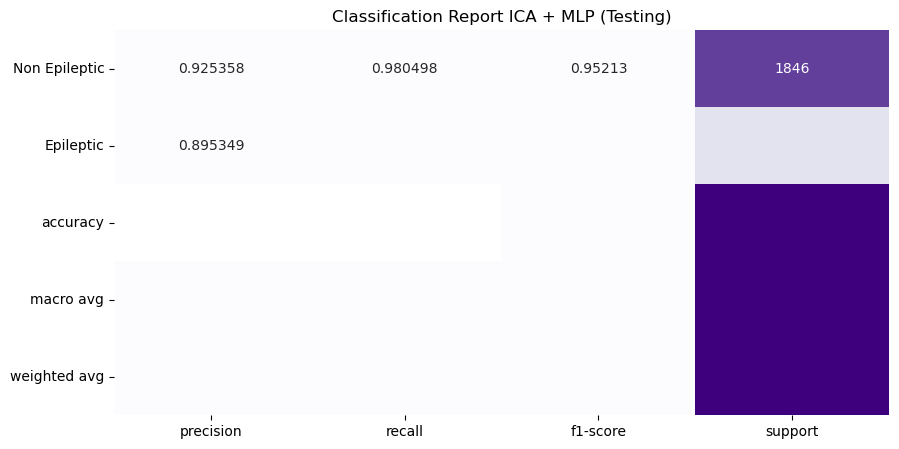

In [22]:
plot_cr_cm(pipe_ica_mlp, x_train, y_train, [0, 1], ['Non Epileptic', 'Epileptic'], 'ICA + MLP (Training)', model_type = 'sklearn')
plot_cr_cm(pipe_ica_mlp, x_test, y_test, [0, 1], ['Non Epileptic', 'Epileptic'], 'ICA + MLP (Testing)', model_type = 'sklearn')

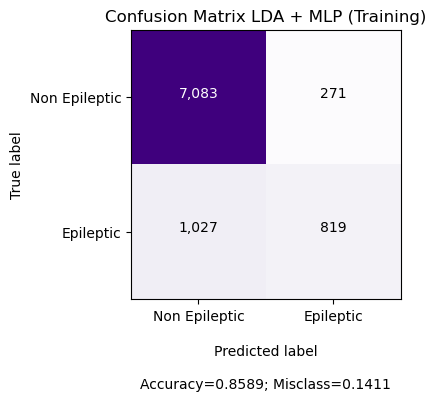

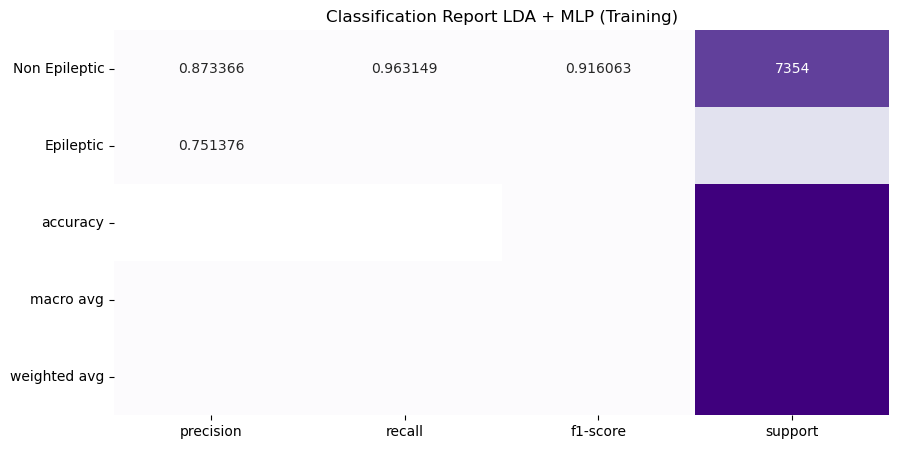

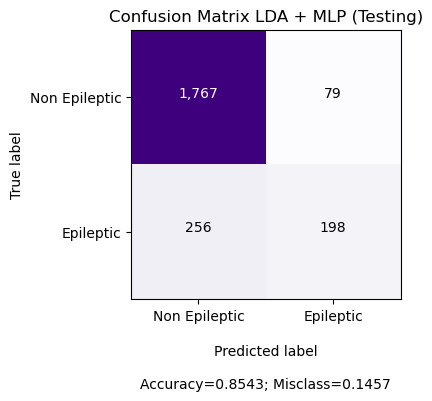

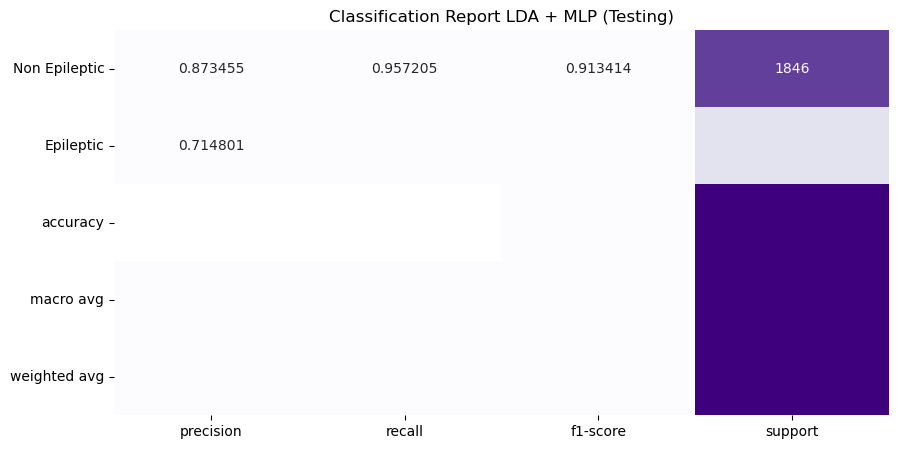

In [23]:

plot_cr_cm(pipe_lda_mlp, x_train, y_train, [0, 1], ['Non Epileptic', 'Epileptic'], 'LDA + MLP (Training)', model_type = 'sklearn')
plot_cr_cm(pipe_lda_mlp, x_test, y_test, [0, 1], ['Non Epileptic', 'Epileptic'], 'LDA + MLP (Testing)', model_type = 'sklearn')

In [24]:

model_eeg, history_eeg = SigXNet(input_shape=(178, 1), classes=2, X_train=x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), Y_train=y_train.to_numpy(), X_test=x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), Y_test=y_test.to_numpy())
     

Model: "SigXNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling1d (MaxPooling1  (None, 89, 1)             0         
 D)                                                              
                                                                 
 conv1d (Conv1D)             (None, 83, 26)            208       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 83, 26)            0         
                                                                 
 batch_normalization (Batch  (None, 83, 26)            104       
 Normalization)                                                  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 26)            0         
 g1D)                                                            
                                                           

72/72 [==============================] - 0s 2ms/step


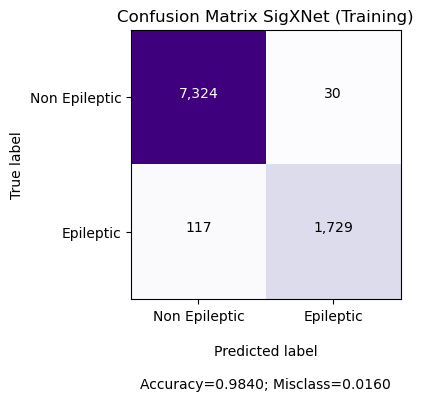

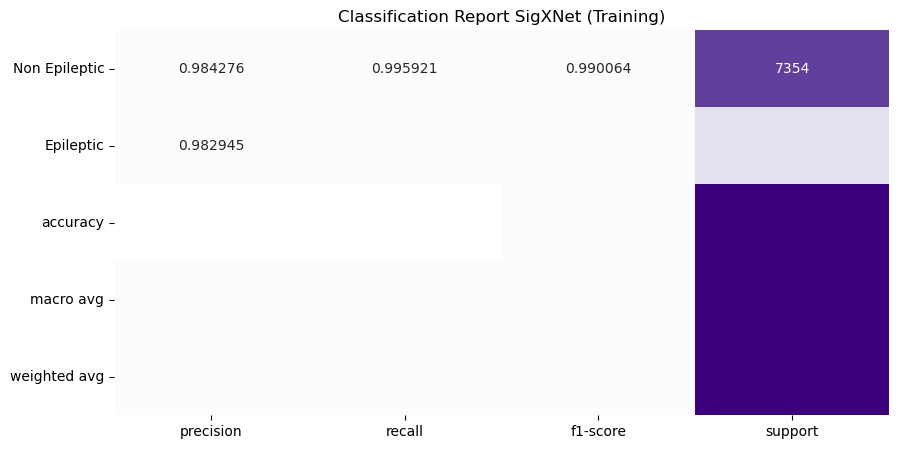

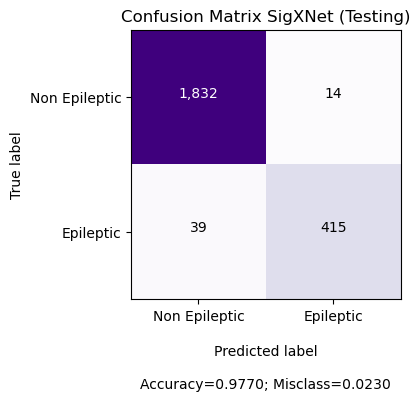

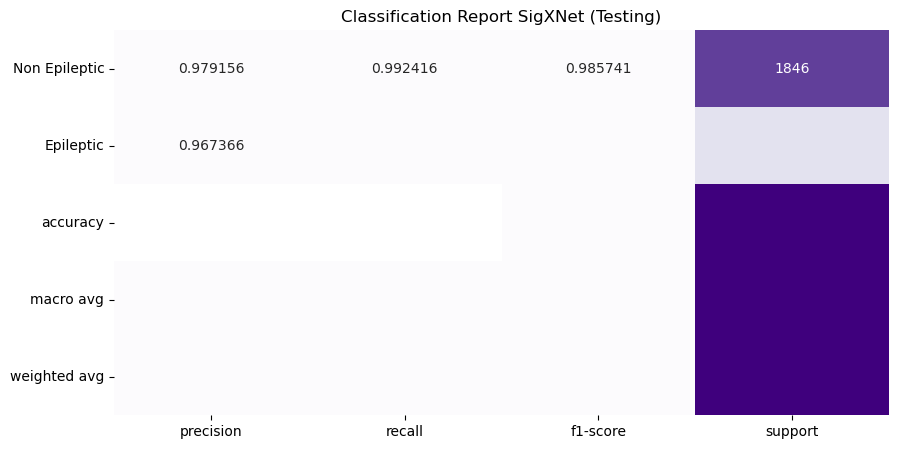

In [25]:

train_y_preds = np.argmax(model_eeg.predict(x_train.reshape((x_train.shape[0], x_train.shape[1], 1))), axis = 1)
test_y_preds = np.argmax(model_eeg.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], 1))), axis = 1)

plot_cr_cm(model = model_eeg, x_data = None, y_true = y_train.to_numpy(), labels = [0, 1], target_names = ['Non Epileptic', 'Epileptic'], title = 'SigXNet (Training)', y_preds = train_y_preds)
plot_cr_cm(model = model_eeg, x_data = None, y_true = y_test.to_numpy(), labels = [0, 1], target_names = ['Non Epileptic', 'Epileptic'], title = 'SigXNet (Testing)', y_preds = test_y_preds)

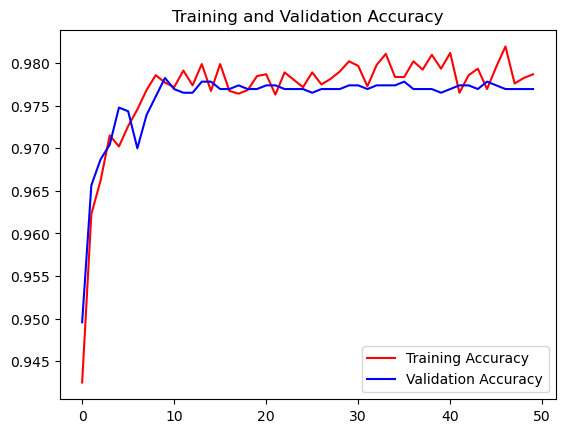

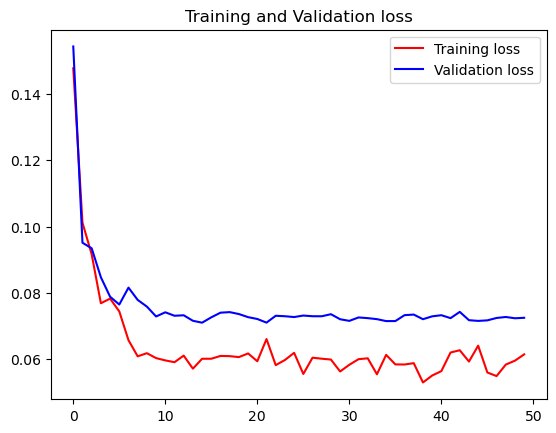

In [26]:
accuracy = history_eeg.history['accuracy']
val_accuracy = history_eeg.history['val_accuracy']
loss = history_eeg.history['loss']
val_loss = history_eeg.history['val_loss']

epochs = range(len(accuracy))
 
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [27]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    # plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color())

def plot_learning_curve(model, scoring = 'accuracy', cv = 2):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(model,
                                                  x_data.to_numpy(), y_data.to_numpy().ravel(), train_sizes = train_sizes, cv = cv,
                                                  scoring = scoring)
    plot_with_err(N_train, val_train, label='Training ' + scoring)
    plot_with_err(N_train, val_test, label='Validation ' + scoring)
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

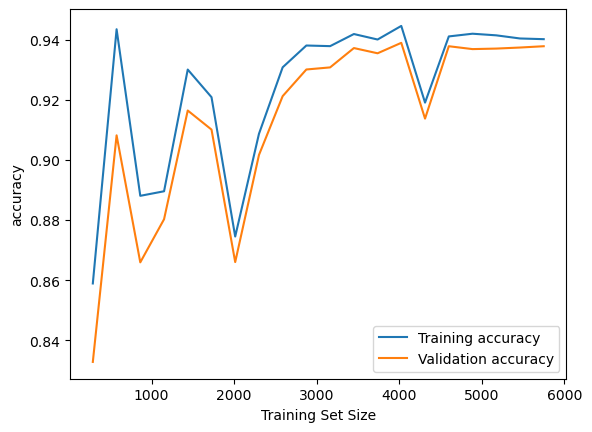

In [28]:
plot_learning_curve(pipe_pca_mlp, scoring = 'accuracy', cv = 2)


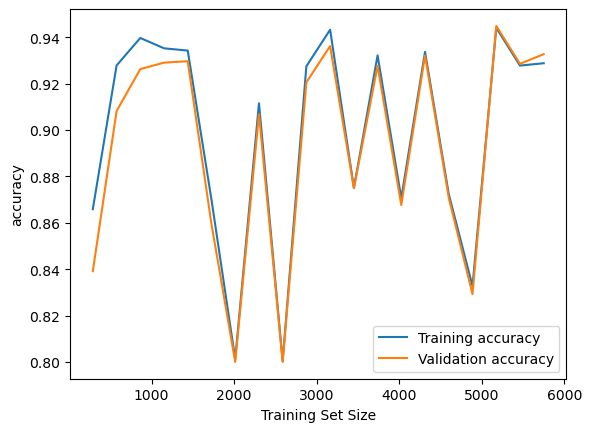

In [29]:
plot_learning_curve(pipe_ica_mlp, scoring = 'accuracy', cv = 2)


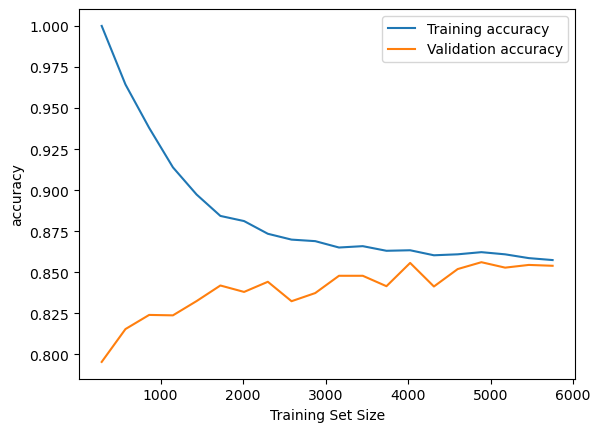

In [30]:
plot_learning_curve(pipe_lda_mlp, scoring = 'accuracy', cv = 2)


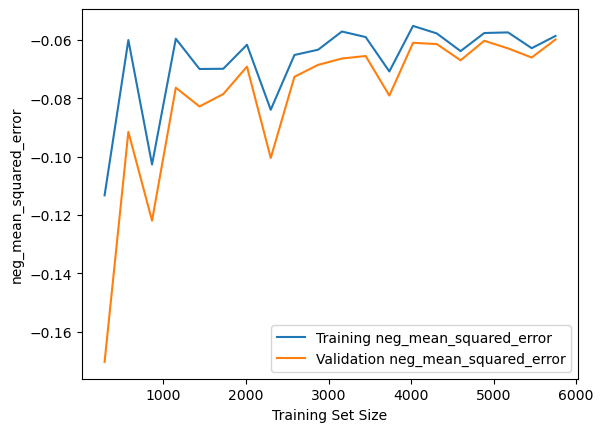

In [31]:
plot_learning_curve(pipe_pca_mlp, scoring = 'neg_mean_squared_error', cv = 2)
